In my previous notebooks, I run `tractor` in an iterative way: add several sources each time and have the model optimized. But I noticed that in the `legacypipe`, Dustin Lang runs `tractor` on a [blob-by-blob basis](https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#fitting): in order of brightness, 

Model selection when DECaLS tractor catalog is not available: https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#model-selection, https://github.com/legacysurvey/legacypipe/blob/6d1a92f8462f4db9360fb1a68ef7d6c252781027/py/legacypipe/oneblob.py#L605


## This notebook demonstrate how to model the 10 lucky dwarf galaxies in HSC images using [`the tractor`](https://github.com/dstndstn/tractor). 
- `tractor` asks for flux, shape, and morphology type (exponential or Sersic) to initialize a model. In this notebook, the flux and shape are taken from the output of Source Extractor Python (`sep`). The morphology type is taken from the DECaLS catalog (by cross-matching `sep` output catalog with DECaLS catalog). 

- Need help when installing `the tractor`? Check [this website](https://astrojacobli.github.io/blog/2018/10/Macbook-for-Astronomy#install-the-tractor).
- You need to install [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) to run this notebook. `kuaizi` contains some handy tools I often use.

In [9]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

NameError: name 'Table' is not defined

In [11]:
obj_cat['name']

<Column name='name' dtype='bytes18' length=10>
s18a_wide_226984_y
s18a_wide_233677_y
s18a_wide_238189_y
s18a_wide_240617_y
s18a_wide_255782_y
s18a_wide_265172_y
s18a_wide_274464_y
s18a_wide_275931_y
s18a_wide_277061_y
s18a_wide_301016_y

In [12]:
import scarlet # I only use this package to generate RGB image for display purpose.
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Let's fit a dwarf step by step

In [51]:
channels = 'grizy'

obj = obj_cat[0]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [52]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

(-0.5, 178.5, -0.5, 178.5)

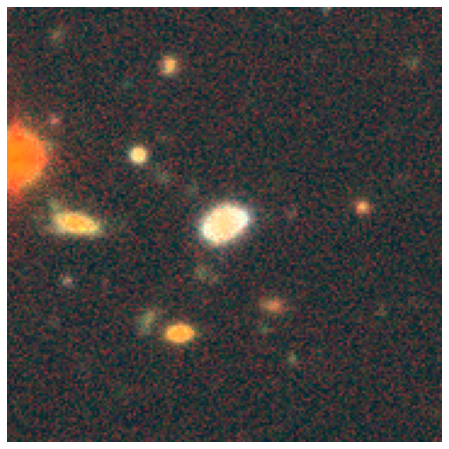

In [53]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb, origin='lower')
plt.axis('off')

In [54]:
## Use Source Extractor to deblend and initialize `tractor`
from kuaizi.tractor.utils import makeCatalog

filt = 'i'
layer_ind = channels.index(filt)

    Detected 18 objects


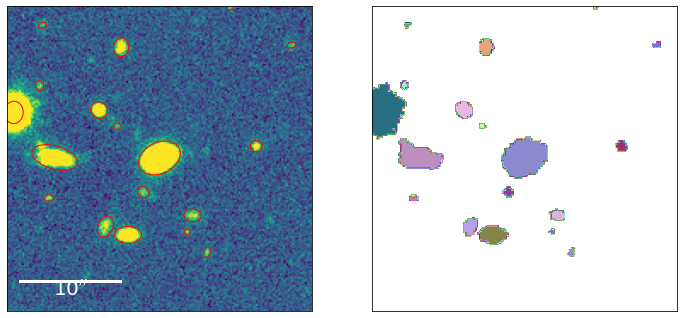

In [55]:
# typical Source Extractor Python (SEP) run, with relatively-low sigma
obj_cat_sep, segmap_sep = makeCatalog(
    [data],
    layer_ind=layer_ind,
    lvl=2.5,
    mask=None,
    method='vanilla',
    convolve=False, 
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=0.168,
    minarea=5,
    deblend_nthresh=48,
    deblend_cont=0.005,
    sky_subtract=True)

In [56]:
## Download DECaLS tractor catalogs and match SEP detection with the tractor catalog
from astropy.table import vstack
from astropy.coordinates import match_coordinates_sky

# DR9 brick catalog, downloaded from https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/
bricks_cat = Table.read(
    '/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz', format='fits')  
# Match bricks with SEP detection
bricks_corr = SkyCoord(
    ra=np.array(bricks_cat['RA']) * u.degree,
    dec=np.array(bricks_cat['DEC']) * u.degree)
detect_coor = SkyCoord(
    ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

to_download = bricks_cat[np.unique(
    match_coordinates_sky(detect_coor, bricks_corr)[0])]
bricknames = to_download['BRICKNAME'].data.astype(
    str)  # in case that there are more than one `tractor` file
print('We need bricks: ', bricknames)
# `bricknames` are tractor files we need.

We need bricks:  ['1496p015' '1496p017']


In [58]:
# Download tractor catalog of the corresponding brick
# This could be time-consuming, depending on internet connection. 
# Maybe we can work on a cluster (such as NERSC or `tiger`) where these `tractor catalogs` can be pre-downloaded.  
tractor_cat = kuaizi.download.download_decals_tractor_catalog(bricknames, layer='dr9', overwrite=False)

https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits


./tractor-1496p015.fits: 11.1MB [00:10, 1.01MB/s]                            


# Downloading ./tractor-1496p015.fits finished! 
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits


./tractor-1496p017.fits: 10.3MB [01:11, 143kB/s]                             


# Downloading ./tractor-1496p017.fits finished! 


In [161]:
# Match these galaxies with DECaLS tractor file and get their morphology types
decals_corr = SkyCoord(
    ra=np.array(tractor_cat['ra']) * u.degree,
    dec=np.array(tractor_cat['dec']) * u.degree)
detect_coor = SkyCoord(ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

temp = tractor_cat[match_coordinates_sky(detect_coor, decals_corr)[0]]
for columns in temp.columns:
    obj_cat_sep.add_column(temp[columns], rename_duplicate=True)
obj_cat_sep.sort('flux', reverse=True)
obj_cat_sep

<Table length=18>
obj_type index         x          ...  shape_e2_1 shape_e2_ivar_1
                                  ...                            
 object  int64      float64       ...   float32       float32    
-------- ----- ------------------ ... ----------- ---------------
    None     0  3.354599942604728 ...         0.0             0.0
    None     1  89.03520985792889 ... -0.24712697       26489.371
    None     2 27.422886192695454 ...  0.21498318       1461.1251
    None     3  70.56993484511352 ...         0.0             0.0
    None     4 53.565032026913016 ...         0.0             0.0
    None     5   66.4777264665977 ...         0.0             0.0
    None     6  57.29800885715483 ...         0.0             0.0
    None     7 108.47676709395266 ... -0.24712697       26489.371
    None     8  145.9507882675506 ...         0.0             0.0
    None     9  79.63529134169502 ... -0.24712697       26489.371
    None    10  18.56736512419772 ...         0.0             0.0
    None    11 24.019588494510206 ...    0.210268       1455.7157
    None    12 116.89154207378894 ...         0.0             0.0
    None    13  166.7174763760359 ...         0.0             0.0
    None    14  64.19575332446679 ...         0.0             0.0
    None    15 105.31460472735627 ...         0.0             0.0
    None    16 20.257497395396417 ...         0.0             0.0
    None    17 130.74425149774973 ...         0.0             0.0

In [207]:
catalog_c = SkyCoord(obj_cat_sep['ra'], obj_cat_sep['dec'], unit='deg')
dist = coord.separation(catalog_c)
cen_obj_ind = np.argsort(dist)[0]
cen_obj = obj_cat_sep[cen_obj_ind]
### Add a "target" column to indicate which object is the target galaxy ###
obj_cat_sep['target'] = np.zeros(len(obj_cat_sep), dtype=int)
obj_cat_sep['target'][cen_obj_ind] = 1

print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(obj_cat_sep)}')

# Type of central object is SER
# Total number of objects: 18


 - Now you have 2 sources
 - Now you have 18 sources


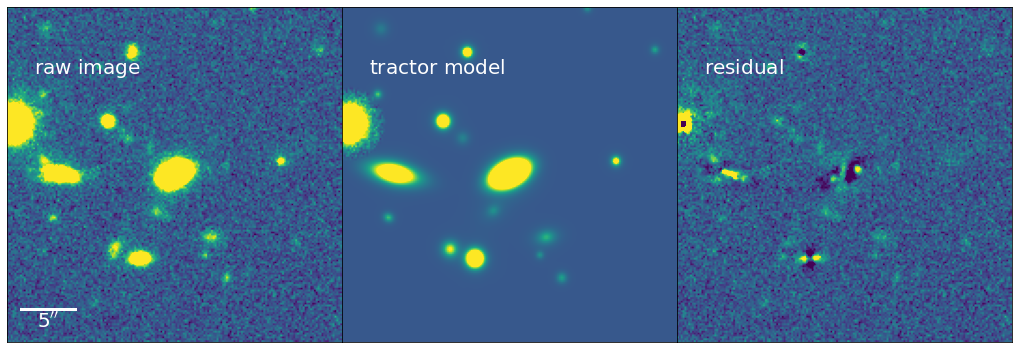

   The chi-square is 7.212782e-05


In [214]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_iteration(
    obj_cat_sep,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='decals',
    freeze_dict={'pos': True, 'shape': True, 'sersicindex': False},
    kfold=2, # how many rounds 
    first_num=cen_obj_ind + 1, # the number of objects for the first round
    fig_name='test')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

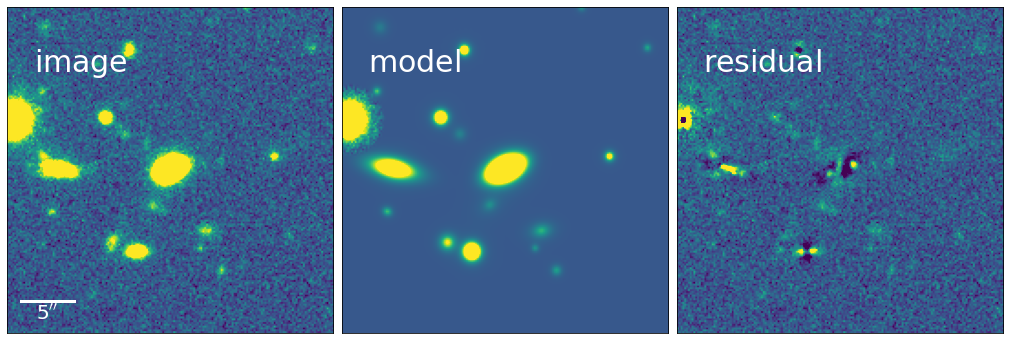

In [295]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

with HiddenPrints():
    trac_mod = trac_obj.getModelImage(0, srcs=sources)

kuaizi.display.display_multiple(
    [data.images[layer_ind], trac_mod, data.images[layer_ind] - trac_mod],
    text=['image', 'model', 'residual'],
    ax=axes,
    scale_bar_y_offset=0.4)

## I've incorporate the above steps into `kuaizi.tractor.utils.tractor_sep` function.

In [4]:
from kuaizi.tractor.utils import tractor_hsc_sep

In [2]:
channels = 'grizy'

In [3]:
# Save all the files to './sep-decals'
import os
os.chdir('./sep-decals/')

### `s18a_wide_233677` i-band
    Detected 20 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1501p017.fits ./tractor-1501p017.fits
!!!The file "./tractor-1501p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 20
# Central object index in i-band: 3
 - Now you have 4 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 719.925 and EllipseE: re=2.27256, e1=-0.097125, e2=0.53479, Sersic index 1.000
 - Now you have 12 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 1283.32 and EllipseE: re=4.34681, e1=-0.107587, e2=0.700693, Sersic index 1.035
   The chi-square is 5138.908
 - Now you have 20 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 712.457 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982


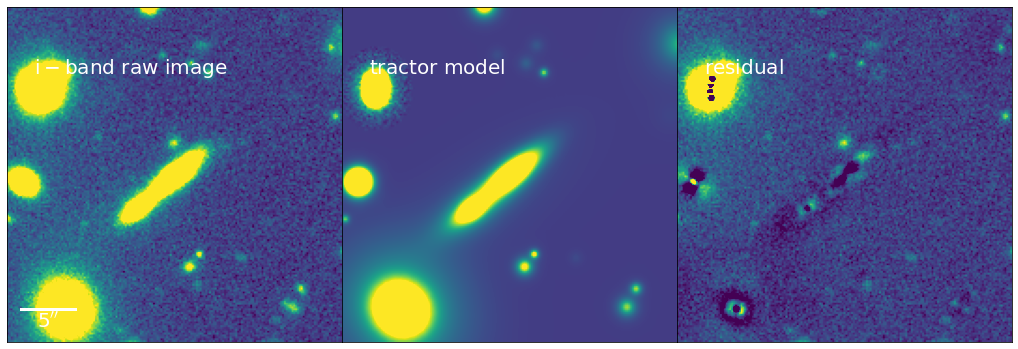

   The chi-square is 5146.786
### `s18a_wide_233677` g-band
    Detected 14 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1501p017.fits ./tractor-1501p017.fits
!!!The file "./tractor-1501p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 14
# Central object index in g-band: 2
 - Now you have 3 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 712.457 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
 - Now you have 8 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 405.25 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
   The chi-square is 1445.5859
 - Now you have 13 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 405.11 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982


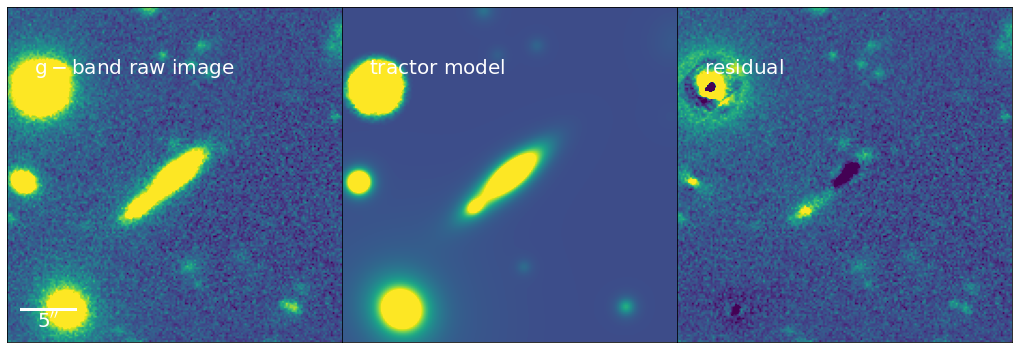

   The chi-square is 1437.8107
### `s18a_wide_233677` r-band
    Detected 13 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1501p017.fits ./tractor-1501p017.fits
!!!The file "./tractor-1501p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 13
# Central object index in r-band: 2
 - Now you have 3 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 405.11 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
 - Now you have 8 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 643.545 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
   The chi-square is 1868.74
 - Now you have 13 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 643.545 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982


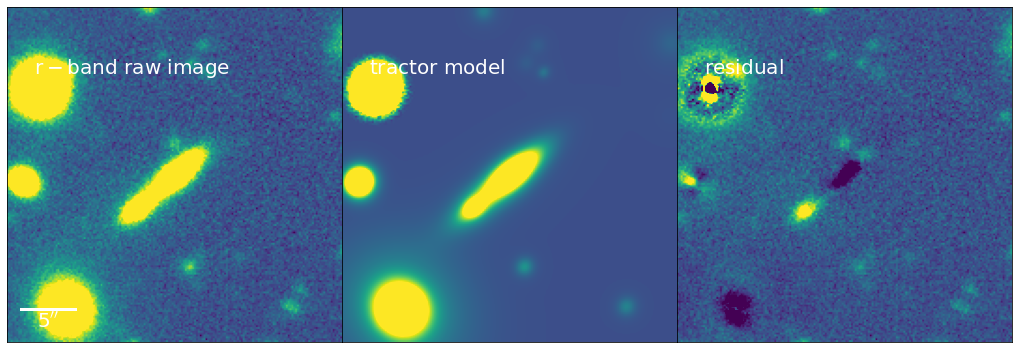

   The chi-square is 1851.8739
### `s18a_wide_233677` z-band
    Detected 16 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1501p017.fits ./tractor-1501p017.fits
!!!The file "./tractor-1501p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 16
# Central object index in z-band: 2
 - Now you have 3 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 643.545 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
 - Now you have 9 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 886.183 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
   The chi-square is 6040.184
 - Now you have 15 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 776.618 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982


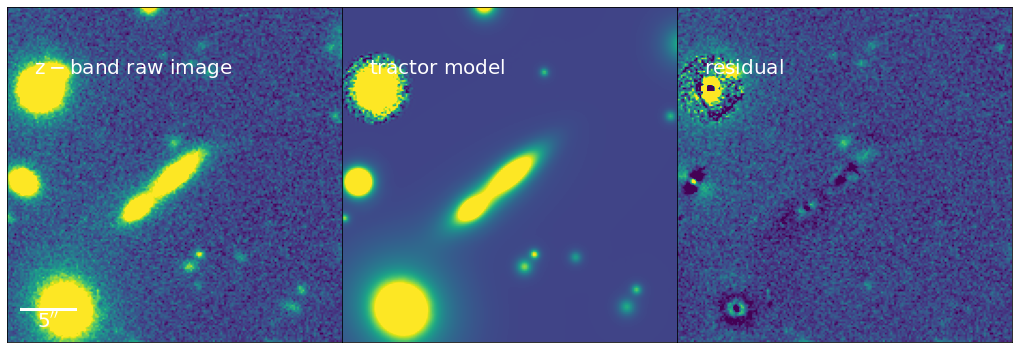

   The chi-square is 6034.7734
### `s18a_wide_233677` y-band
    Detected 9 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1501p017.fits ./tractor-1501p017.fits
!!!The file "./tractor-1501p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 9
# Central object index in y-band: 3
 - Now you have 4 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 776.771 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
 - Now you have 6 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 1006.73 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982
   The chi-square is 11102.743
 - Now you have 8 sources
Target source: SersicGalaxy at pixel (89.86, 88.92) with Flux: 874.661 and EllipseE: re=2.01805, e1=-0.109282, e2=0.54251, Sersic index 0.982


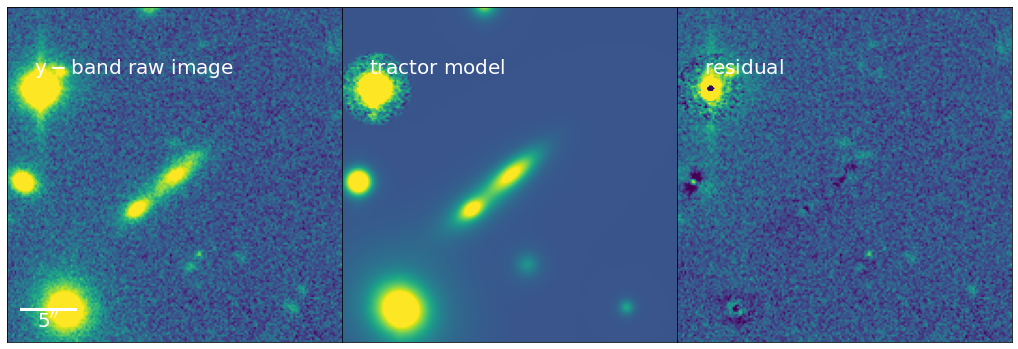

   The chi-square is 11158.878


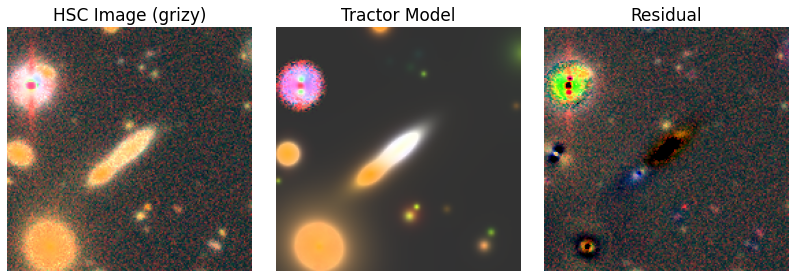

In [330]:
channels = 'grizy'
forced_channels = 'grzy'

for obj in obj_cat[0:1]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
    model_dict = {}
    
    ref_filt = 'i'
    model_dict[ref_filt] = tractor_hsc_sep(obj, ref_filt, channels, data, 
                                           freeze_dict={'pos': True, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
                                           brick_file='/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz',
                                           verbose=False)

    for filt in forced_channels:
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                           freeze_dict={'pos': True, 'shape': True, 'sersicindex': True},
                                           # Add the optimzed target galaxy in i-band as reference model, for other bands' fitting
                                           ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
                                           brick_file='/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz',
                                           verbose=False)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    
    ### Make figures into a PDF file (slow)
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_sep_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_sep_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})
    

    #clear_output()
    #plt.close()

In [ ]:
# As you see above, the pos, shape, and Sersic index of the target galaxy in `grzy` bands are fixed!

In [329]:
#### As you can see below, the target galaxy (source1) doesn't have `pos` attribute, meaning that `pos` is frozen!
list(zip(model_dict['r'].catalog.getParamNames(), model_dict['r'].catalog.getParams()))

[('source0.pos.x', 2.8625357750508735),
 ('source0.pos.y', 116.12401765298101),
 ('source0.brightness.Flux', 1122.643586058516),
 ('source1.brightness.Flux', 461.6855287059988),
 ('source2.pos.x', 27.719807122247744),
 ('source2.pos.y', 89.45387397576165),
 ('source2.brightness.Flux', 126.68759478929302),
 ('source2.shape.re', 1.3997093800791949),
 ('source2.shape.e1', -0.4693336044890509),
 ('source2.shape.e2', -0.17316330537025446),
 ('source3.pos.x', 70.88338967060655),
 ('source3.pos.y', 44.11110186708245),
 ('source3.brightness.Flux', 44.29197121149367),
 ('source3.shape.re', 0.32042880724419526),
 ('source4.pos.x', 53.3214851503367),
 ('source4.pos.y', 117.38165719839606),
 ('source4.brightness.Flux', 39.018320585593315),
 ('source4.shape.re', 0.22700126294360284),
 ('source5.pos.x', 57.46387633534174),
 ('source5.pos.y', 48.98978590013019),
 ('source5.brightness.Flux', 24.352622157869853),
 ('source5.shape.re', 0.7245533740698302),
 ('source6.pos.x', 66.27026398844502),
 ('sourc